In [ ]:
!pip install -r requirements.txt

In [1]:
import os
os.environ["HF_TOKEN"] = ""

In [2]:
from datasets import load_metric
import nltk

# Загрузка необходимых ресурсов для NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# Импорт метрик
rouge = load_metric('rouge')
bleu = load_metric('bleu')
meteor = load_metric('meteor')
bertscore = load_metric('bertscore')

def evaluate_metrics(predictions, references, article, metrics):
    # Преобразование текстов для BLEU метрики
    bleu_predictions = [prediction.split() for prediction in predictions]
    bleu_references = [[reference.split()] for reference in references]
    
    results = {}
    
    for metric in metrics:
        if metric == "bleu":
            results["bleu"] = bleu.compute(predictions=bleu_predictions, references=bleu_references)
        elif metric == "bertscore":
            results["bertscore"] = bertscore.compute(predictions=predictions, references=references, lang='en')
        else:
            results[metric] = globals()[metric].compute(predictions=predictions, references=references)
    
    return results

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\victor\AppData\Local\Temp\ipykernel_7616\1663935692.py:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')
C:\Users\victor\IAD_course_project\pythonProject\.venv\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the reposi

In [3]:
from datasets import load_dataset

# Загрузка датасета CNN/DailyMail
cnn_dailymail = load_dataset("cnn_dailymail", "3.0.0")

In [4]:
import torch
from transformers import pipeline, TextGenerationPipeline, SummarizationPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_settings = {
    "t5": {"model": "google/flan-t5-large", "batch_size": 2},
    "bart": {"model": "facebook/bart-large", "batch_size": 2},
    "llama": {"model": "meta-llama/Meta-Llama-3-8B-Instruct", "batch_size": 2},
    "mistral": {"model": "mistralai/Mistral-7B-Instruct-v0.3", "batch_size": 2},
}

def upload_model(model_name, device=0):
    if model_name in ['mistral', 'llama']:
        model_settings = models_settings[model_name]
        summarizer = pipeline('text-generation', **model_settings, device=device, torch_dtype=torch.bfloat16)
    else:
        model_settings = models_settings[model_name]
        summarizer = pipeline('summarization', **model_settings, device=device, torch_dtype=torch.bfloat16)
    return summarizer


def summarize_bart(model, text, max_new_tokens, max_length=1000, stride=512):
    # Разбиваем текст на предложения
    sentences = nltk.sent_tokenize(text)
        
    summaries = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        tokenized_sentence = model.tokenizer(sentence)["input_ids"]
        sentence_length = len(tokenized_sentence)
        
        if current_length + sentence_length > max_length:
            chunk = model.tokenizer.decode(current_chunk)
            result = model(chunk, max_length=max_new_tokens, min_length=30, do_sample=False)
            summaries.append(result[0]["summary_text"])
            
            current_chunk = tokenized_sentence
            current_length = sentence_length
        else:
            current_chunk.extend(tokenized_sentence)
            current_length += sentence_length
    
    if current_chunk:
        chunk = model.tokenizer.decode(current_chunk)
        result = model(chunk, max_length=max_new_tokens, min_length=30, do_sample=False)
        summaries.append(result[0]["summary_text"])
    
    # Объединяем полученные саммари
    final_summary = " ".join(summaries)
    
    # Если финальное саммари все еще слишком длинное, суммаризируем его еще раз
    if len(model.tokenizer(final_summary)["input_ids"]) > max_length:
        final_summary = model(final_summary, max_length=max_new_tokens, min_length=30, do_sample=False)[0]["summary_text"]
    
    return final_summary


def summarize(model: pipeline, text, _=None):
    max_new_tokens = int(len(text.split(" "))/2) if int(len(text.split(" "))/2) < 150 else 150
    max_new_words = 0.75 * max_new_tokens
    messages = [
    {"role": "user", "content": ""}
    ]
    mistral_prompt = f'''Please provide a brief but comprehensive summary of the main ideas and important details. I need less then {max_new_words} words.

    Text for summarization:
    
    {text}
    '''
    llama_prompt = f"{text}\nExplain the above in two sentences:"
    if isinstance(model, TextGenerationPipeline):
        if model.model.config.model_type == 'llama':
            messages[0]['content'] = llama_prompt
        else:
            messages[0]['content'] = mistral_prompt
        result = model(messages, max_new_tokens=max_new_tokens)
        return result[0]["generated_text"][-1]['content']
    elif isinstance(model, SummarizationPipeline):
        if 'bart' in model.model.config.model_type:
            result = summarize_bart(model, text, max_new_tokens=max_new_tokens)
            return result
        else:
            result = model(text, max_new_tokens=max_new_tokens)
            return result[0]["summary_text"]
    else:
        raise NotImplementedError(type(model))


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer

nlp = spacy.load("en_core_web_sm")
extractive_model = SentenceTransformer('all-mpnet-base-v2')

def rank_sentences(sentences):
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)
    # Композитный вектор документа
    doc_vector = sentence_vectors.mean(axis=0)
    # Вычисляем косинусное сходство каждого предложения с документом
    similarity_scores = cosine_similarity(sentence_vectors, np.asarray(doc_vector))
    return similarity_scores.flatten()

def sentence_ranking_extraction(model, text, num_sentences=3):
    sentences = nltk.sent_tokenize(text)
    sentence_scores = rank_sentences(sentences)  # Функция для ранжирования предложений
    top_sentences = [sentences[i] for i in np.argsort(sentence_scores)[-num_sentences:]]
    summary = " ".join(top_sentences)
    return summarize(model, summary)

def hybrid_summarization(model, text, num_sentences=3):
    sentences = nltk.sent_tokenize(text)
    sentence_embeddings = extractive_model.encode(sentences)
    sentence_scores = np.mean(sentence_embeddings, axis=1) 
    top_indices = np.argsort(sentence_scores)[-num_sentences:]
    extracted_sentences = [sentences[i] for i in top_indices]
    extracted_text = " ".join(extracted_sentences)
    return summarize(model, extracted_text)

def extract_keyphrases(text, num_keyphrases):
    doc = nlp(text)
    keyphrases = [chunk.text for chunk in doc.noun_chunks if len(chunk.text.split()) > 1]
    keyphrase_scores = [(keyphrase, np.sum([token.vector_norm for token in nlp(keyphrase)])) for keyphrase in keyphrases]
    top_keyphrases = [k[0] for k in sorted(keyphrase_scores, key=lambda x: x[1], reverse=True)[:num_keyphrases]]
    return top_keyphrases

def content_planning(model, text, num_keyphrases=5):
    keyphrases = extract_keyphrases(text, num_keyphrases)  # Функция для извлечения ключевых фраз
    keyphrase_text = ", ".join(keyphrases)
    summary = summarize(model, f"Keyphrases: {keyphrase_text}\nText: {text}")
    return summary

C:\Users\victor\IAD_course_project\pythonProject\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
import json
from tqdm import tqdm

models = [
            "t5", 
            "bart", 
            "llama",
            "mistral"
]
heuristics = {
    "summarize": {"hyper_parameter_values": [1], "hyper_parameter_name": None},
    "sentence_ranking_extraction": {"hyper_parameter_values": [3,5,7,10], "hyper_parameter_name": "num_sentences"}, 
    "hybrid_summarization": {"hyper_parameter_values": [3,5,7,10], "hyper_parameter_name": "num_sentences"}, 
    "content_planning": {"hyper_parameter_values": [3,5,7,10], "hyper_parameter_name": "num_keyphrases"}
}
metrics = ["rouge", "bleu", "meteor", "bertscore"]
datasets = ["cnn_dailymail"]
for dataset_name in datasets:
    dataset = globals()[dataset_name]
    for model_name in models:
        model = upload_model(model_name)
        for heuristic in heuristics:
            for hyper_parameter_value in heuristics[heuristic]["hyper_parameter_values"]:
                for row in tqdm(dataset["test"], desc=f"Processing {dataset_name} with {model_name} and {heuristic} and {heuristics[heuristic]['hyper_parameter_name']}={hyper_parameter_value}"):
                    # Получение суммаризации
                    summarization = globals()[heuristic](model, row["article"], hyper_parameter_value)
    
                    # Вычисление метрик
                    results = evaluate_metrics([summarization], [row["highlights"]], row["article"], metrics)
    
                    # Сохранение результатов
                    output_data = {
                        "dataset": dataset_name,
                        "model": model_name,
                        "heuristic": heuristic,
                        "hyper_parameter_name": heuristics[heuristic]['hyper_parameter_name'],
                        "hyper_parameter_value": hyper_parameter_value,
                        "article": row["article"],
                        "highlights": row["highlights"],
                        "summarization": summarization,
                        "results": results
                    }
    
                    with open(f"results_final3.json", "a") as f:
                        f.write(json.dumps(output_data) + "\n")
        
        del model
        torch.cuda.empty_cache()

bertscore:       model                                 heuristic_hyper     score
25    llama                              summarize - None=1  0.874875
16    llama             content_planning - num_keyphrases=7  0.873577
13    llama            content_planning - num_keyphrases=10  0.870563
14    llama             content_planning - num_keyphrases=3  0.869771
15    llama             content_planning - num_keyphrases=5  0.868422
42       t5             content_planning - num_keyphrases=7  0.867549
38  mistral                              summarize - None=1  0.867303
40       t5             content_planning - num_keyphrases=3  0.867219
39       t5            content_planning - num_keyphrases=10  0.866813
41       t5             content_planning - num_keyphrases=5  0.866372
27  mistral             content_planning - num_keyphrases=3  0.864653
21    llama  sentence_ranking_extraction - num_sentences=10  0.864506
28  mistral             content_planning - num_keyphrases=5  0.864328
17    lla

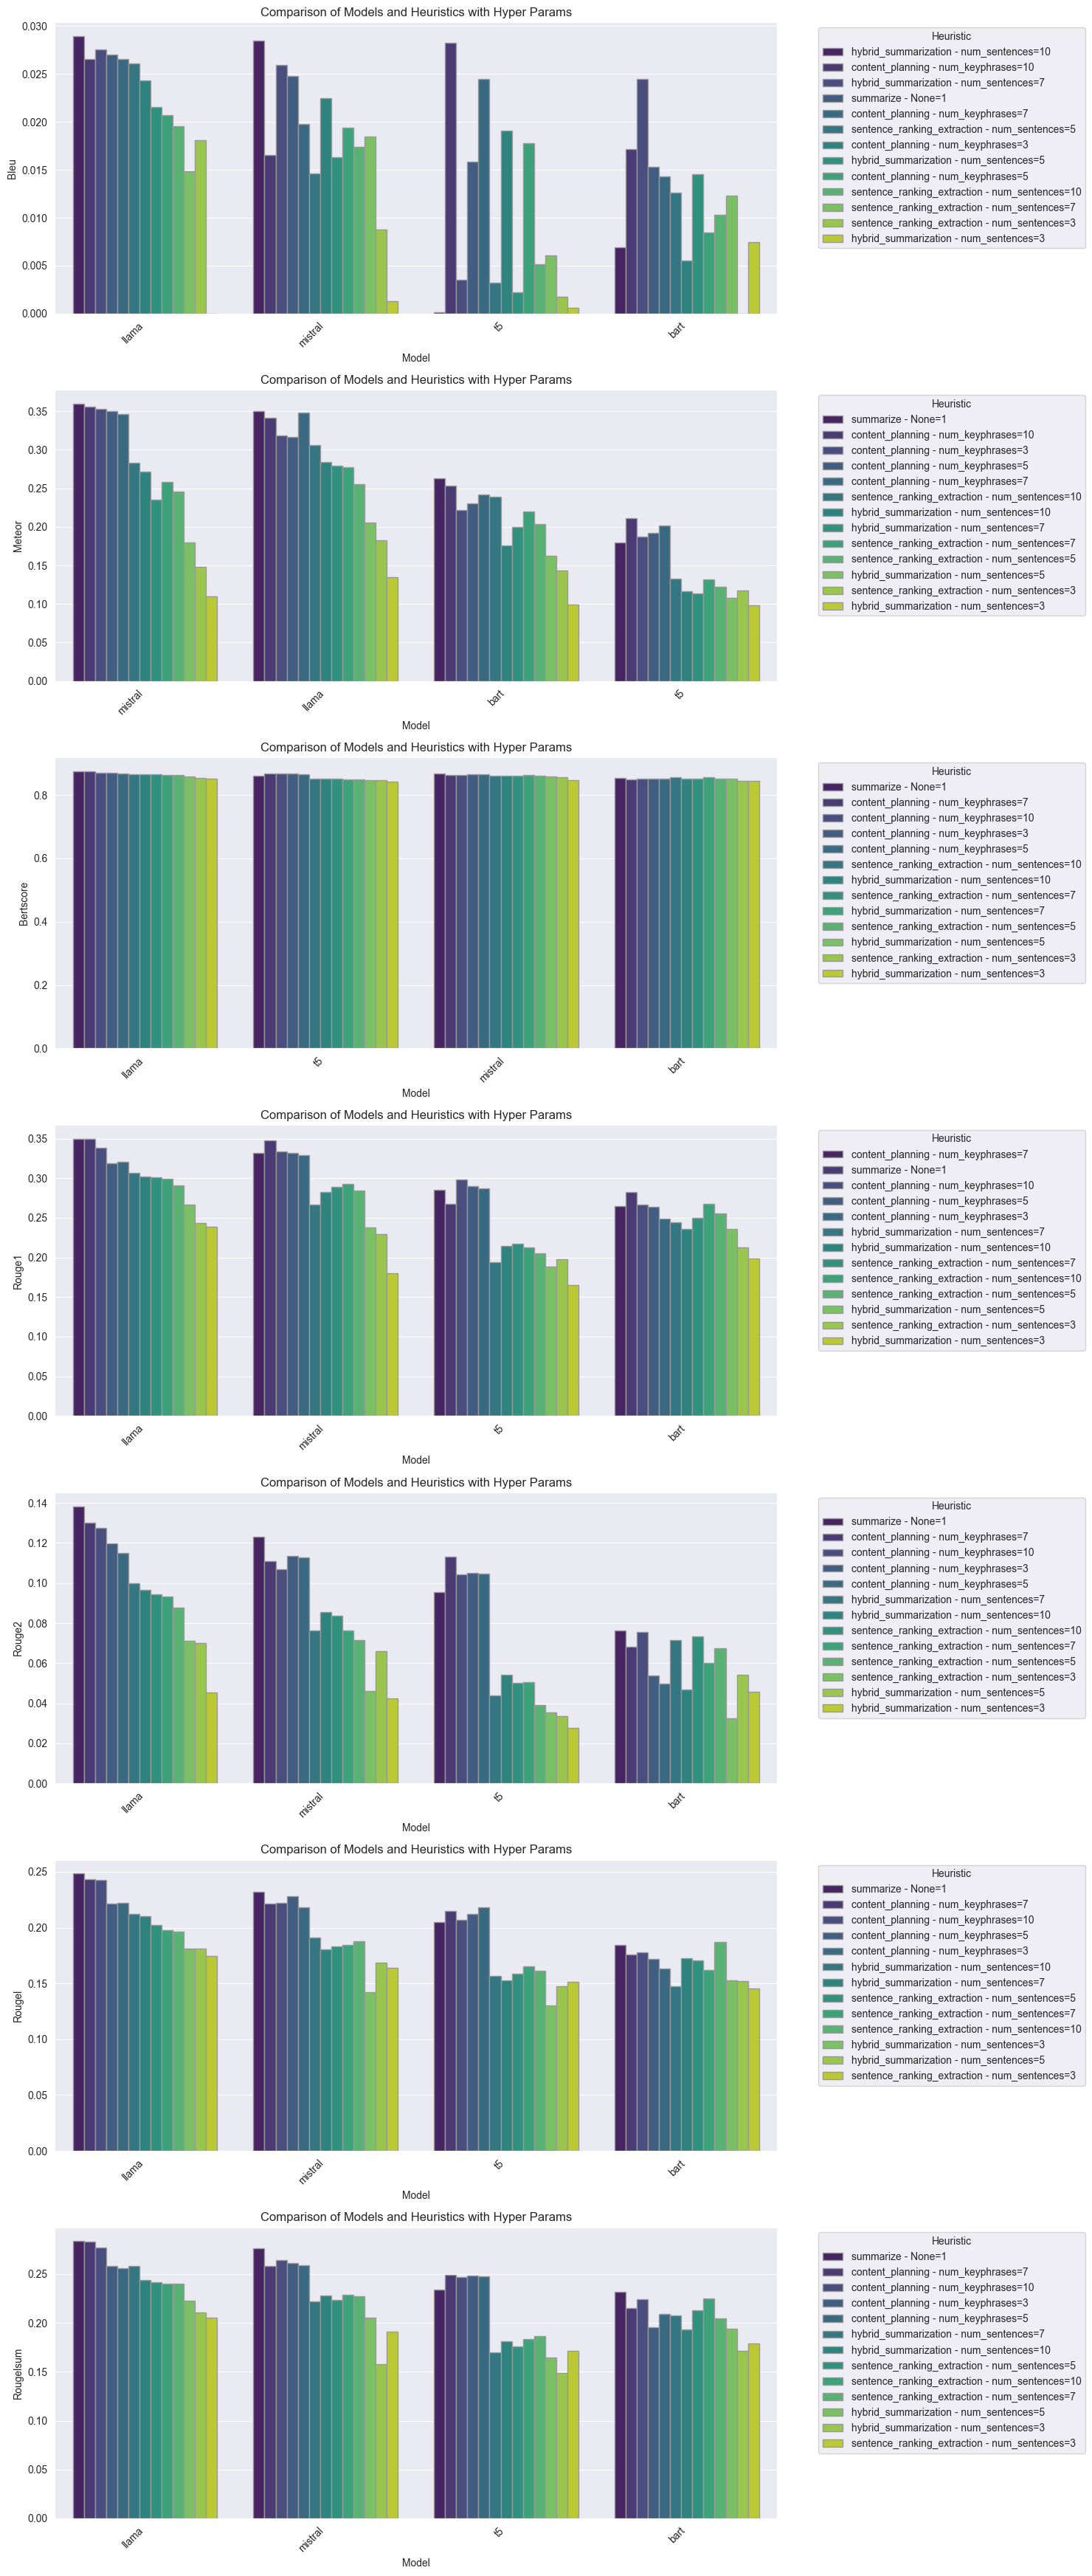

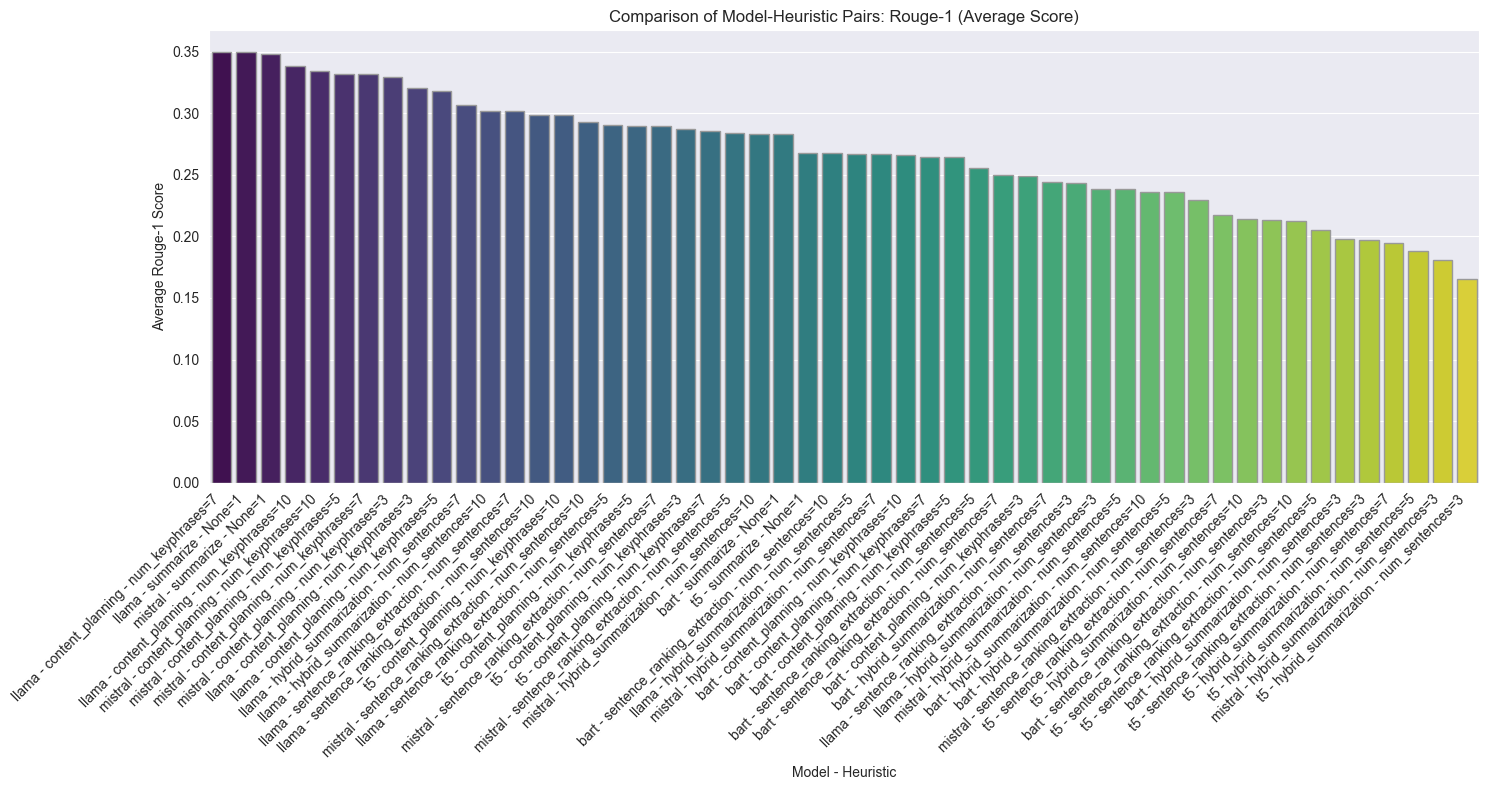

rouge1:                                       model_heuristic     score
16        llama - content_planning - num_keyphrases=7  0.349864
25                         llama - summarize - None=1  0.349729
38                       mistral - summarize - None=1  0.348140
13       llama - content_planning - num_keyphrases=10  0.338544
26     mistral - content_planning - num_keyphrases=10  0.334235
28      mistral - content_planning - num_keyphrases=5  0.332008
29      mistral - content_planning - num_keyphrases=7  0.331821
27      mistral - content_planning - num_keyphrases=3  0.329166
14        llama - content_planning - num_keyphrases=3  0.320839
15        llama - content_planning - num_keyphrases=5  0.318465
20     llama - hybrid_summarization - num_sentences=7  0.306453
17    llama - hybrid_summarization - num_sentences=10  0.302060
24  llama - sentence_ranking_extraction - num_sent...  0.301664
21  llama - sentence_ranking_extraction - num_sent...  0.298985
39          t5 - content_plannin

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Чтение JSON-файла в DataFrame
df = pd.read_json('results_final3.json', lines=True)

# Выделение нужных столбцов
df_plot = df[['model', 'heuristic', 'results', 'hyper_parameter_name', 'hyper_parameter_value']]

df_plot = pd.concat([df_plot.drop(['results'], axis=1), df_plot['results'].apply(pd.Series)], axis=1)
df_plot = pd.concat([df_plot.drop(['rouge'], axis=1), df_plot['rouge'].apply(pd.Series)], axis=1)

# Преобразование данных для удобства визуализации
df_plot = df_plot.melt(id_vars=['model', 'heuristic', 'hyper_parameter_name', 'hyper_parameter_value'], 
                       value_vars=['bleu', 'meteor', 'bertscore', 
                                   'rouge1', 'rouge2', 'rougeL', 'rougeLsum'], 
                       var_name='metric', value_name='score')

z = {
    "bleu": "bleu", 
    "meteor": "meteor", 
    "bertscore": "f1",
    "rouge1": lambda x: sum(x[0]) / len(x[0]),
    "rouge2": lambda x: sum(x[0]) / len(x[0]),
    "rougeL": lambda x: sum(x[0]) / len(x[0]),
    "rougeLsum": lambda x: sum(x[0]) / len(x[0]),
    "summa_qa": "avg_fscore",
}

df_plot['score'] = df_plot.apply(
    lambda row: z[row['metric']](row['score']) if row['metric'].startswith('rouge') else 
    row['score'][z[row['metric']]] if isinstance(row['score'], dict) and isinstance(row['score'][z[row['metric']]], float) else row['score'][z[row['metric']]][0], axis=1)


# Создание отдельного графика для каждой метрики
metrics = df_plot['metric'].unique()
plt.figure(figsize=(15, 5 * len(metrics)))

for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i + 1)
    metric_data = df_plot[df_plot['metric'] == metric]
    
    metric_data['heuristic_hyper'] = metric_data.apply(lambda row: f"{row['heuristic']} - {row['hyper_parameter_name']}={row['hyper_parameter_value']}", axis=1)
    metric_data = metric_data.groupby(['model', 'heuristic_hyper'], as_index=False)['score'].mean()
    metric_data = metric_data.sort_values(by='score', ascending=False)

    sns.barplot(data=metric_data, x='model', y='score', hue='heuristic_hyper', palette='viridis', edgecolor=".6")
    plt.title(f'Comparison of Models and Heuristics with Hyper Params')
    plt.xlabel('Model')
    plt.ylabel(metric.capitalize())
    plt.legend(title='Heuristic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    if metric == "bertscore":
        print("bertscore:", metric_data)


plt.tight_layout()
plt.show()

# Фильтрация данных для метрики rouge1
df_rouge1 = df_plot[df_plot['metric'] == 'rouge1']
# Создание колонки для комбинированных имен моделей и эвристик
df_rouge1['model_heuristic'] = df_rouge1.apply(lambda row: f"{row['model']} - {row['heuristic']} - {row['hyper_parameter_name']}={row['hyper_parameter_value']}", axis=1)

# Вычисление среднего значения для каждой пары
df_rouge1_mean = df_rouge1.groupby('model_heuristic', as_index=False)['score'].mean()

# Сортировка данных по среднему значению rouge1
df_rouge1_mean_sorted = df_rouge1_mean.sort_values(by='score', ascending=False)

# Построение графика
plt.figure(figsize=(15, 8))
sns.barplot(data=df_rouge1_mean_sorted, x='model_heuristic', y='score', palette='viridis', edgecolor=".6")
plt.title('Comparison of Model-Heuristic Pairs: Rouge-1 (Average Score)')
plt.xlabel('Model - Heuristic')
plt.ylabel('Average Rouge-1 Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
print("rouge1:", df_rouge1_mean_sorted)

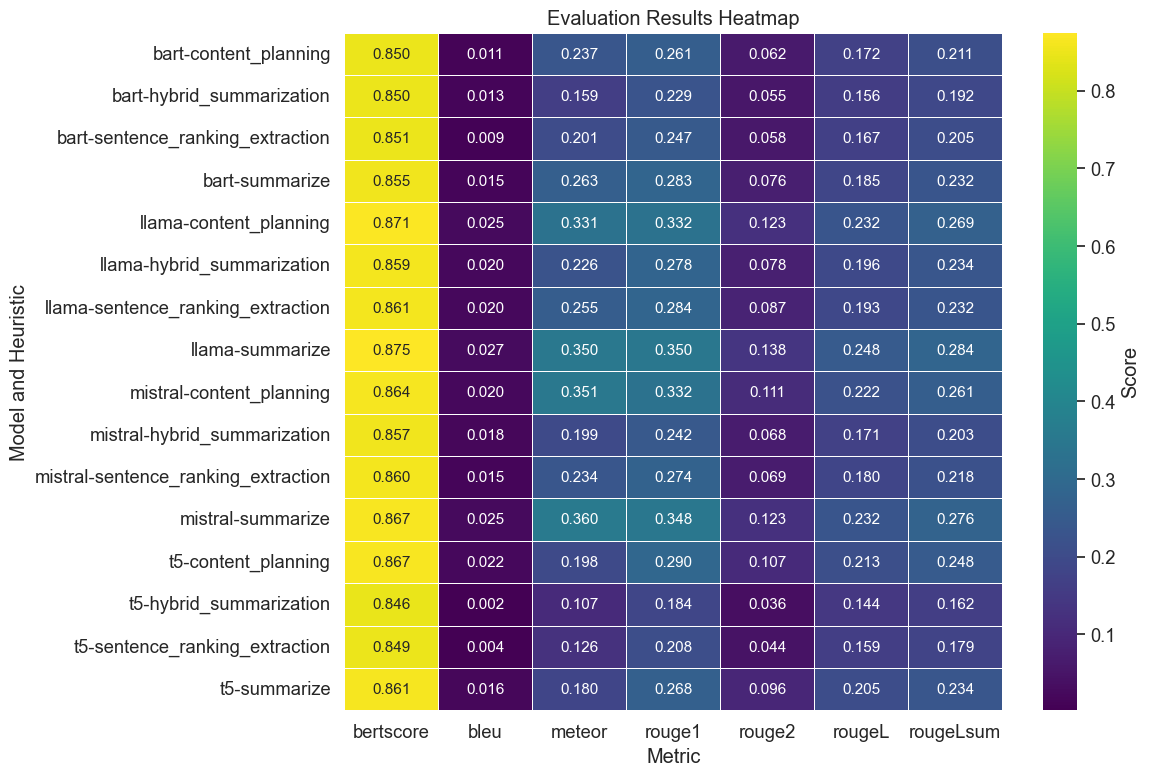

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Чтение JSON-файла в DataFrame
df = pd.read_json('results_final3.json', lines=True)

# Выделение нужных столбцов
df_plot = df[['model', 'heuristic', 'results']]

df_plot = pd.concat([df_plot.drop(['results'], axis=1), df_plot['results'].apply(pd.Series)], axis=1)
df_plot = pd.concat([df_plot.drop(['rouge'], axis=1), df_plot['rouge'].apply(pd.Series)], axis=1)

# Преобразование данных для удобства визуализации
df_plot = df_plot.melt(id_vars=['model', 'heuristic'], 
                       value_vars=['bleu', 'meteor', 'bertscore', 
                                   'rouge1', 'rouge2', 'rougeL', 'rougeLsum'], 
                       var_name='metric', value_name='score')

z = {
    "bleu": "bleu", 
    "meteor": "meteor", 
    "bertscore": "f1",
    "rouge1": lambda x: sum(x[0]) / len(x[0]),
    "rouge2": lambda x: sum(x[0]) / len(x[0]),
    "rougeL": lambda x: sum(x[0]) / len(x[0]),
    "rougeLsum": lambda x: sum(x[0]) / len(x[0]),
    "summa_qa": "avg_fscore",
}

df_plot['score'] = df_plot.apply(
    lambda row: z[row['metric']](row['score']) if row['metric'].startswith('rouge') else 
    row['score'][z[row['metric']]] if isinstance(row['score'], dict) and isinstance(row['score'][z[row['metric']]], float) else row['score'][z[row['metric']]][0], axis=1)

# Создание сводной таблицы
df_pivot = df_plot.pivot_table(index=['model', 'heuristic'], columns='metric', values='score')
df_pivot = df_pivot.reset_index()

# Создание heatmap
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(df_pivot.set_index(['model', 'heuristic']), annot=True, cmap='viridis', linewidths=0.5, fmt='.3f', 
            cbar_kws={'label': 'Score'}, annot_kws={'size': 11})
plt.xlabel('Metric')
plt.ylabel('Model and Heuristic')
plt.title('Evaluation Results Heatmap')
plt.tight_layout()

# Поворот меток на оси y
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()